In [1]:
import numpy as np
import pandas as pd
import copy
from dataclasses import dataclass, field

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

# Model

In [2]:
@dataclass
class Cluster:
    machines: list
    parts: list
    
    def __post_init__(self) -> None:
        self.n_machines = len(self.machines)
        self.n_parts = len(self.parts)
        
    def remove_machine(self, m_id: int) -> None:
        if m_id in self.machines:
            self.machines.remove(m_id)
            self.n_machines -= 1
    
    def add_machine(self, m_id: int) -> None:
        if m_id not in self.machines:
            self.machines.append(m_id)
            self.n_machines += 1
            
    def remove_part(self, p_id: int) -> None:
        if p_id in self.parts:
            self.parts.remove(p_id)
            self.n_parts -= 1
            
    def add_part(self, p_id: int) -> None:
        if p_id not in self.parts:
            self.parts.append(p_id)
            self.n_parts += 1
            
    def __repr__(self) -> str:
        return f"machines={self.machines}\n     parts={self.parts}"

In [3]:
@dataclass
class Solution:
    instance_name: str
    matrix: np.array = field(repr=False)
    clusters: list
    
    ge: float = field(init=False)
    _n_ones_total: int = field(init=False, repr=False)
    
    def __post_init__(self):
        self._n_ones_total = (self.matrix == 1).sum()
        self._update_obj_func()
        
    def __iter__(self):
        return iter(self.clusters)
        
    def replace_cluster(self, old_cl: Cluster, new_cl: Cluster) -> None:
        self.clusters[self.clusters.index(old_cl)] = new_cl
        self._update_obj_func()
        
    def remove_clusters(self, *clusters: Cluster) -> None:
        for cl in clusters:
            self.clusters.remove(cl)
        self._update_obj_func()
        
    def add_clusters(self, *clusters: Cluster) -> None:
        self.clusters.extend(clusters)
        self._update_obj_func()
    
    def _update_obj_func(self) -> None:
        n_ones_in, n_zeros_in = 0, 0
        for cluster in self.clusters:
            for m_id in cluster.machines:
                for p_id in cluster.parts:
                    if self.matrix[m_id-1][p_id-1] == 1:
                        n_ones_in += 1
                    else:
                        n_zeros_in += 1
        self.ge = n_ones_in / (self._n_ones_total + n_zeros_in)
    
    def draw(self, ax=None) -> None:
        def draw_matrix(ax, matrix: np.array, m_ids: np.array=None, p_ids: np.array=None, title: str='') -> None:
            n_machines, n_parts = matrix.shape
            ax.matshow(matrix, cmap='gray_r', aspect="auto")
            ax.set_xticks(range(n_parts))
            ax.set_yticks(range(n_machines))
            if p_ids is not None:
                ax.set_xticklabels(p_ids)
            if m_ids is not None:
                ax.set_yticklabels(m_ids)
            if title:
                ax.set_title(title, fontsize=14)
            
            clusters_info = "Clusters:\n" + "\n".join(f"{i: 2d}) {cl}"
                                                      for i, cl in enumerate(self.clusters, start=1))
            ax.annotate(clusters_info, xy=(0, 0), xytext=(0, -10), fontsize=14,
                        xycoords='axes fraction', textcoords='offset points', va='top')
    
        result_m_ids = np.concatenate([cl.machines for cl in self.clusters])
        result_p_ids = np.concatenate([cl.parts for cl in self.clusters])
        m = self.matrix[[m_id-1 for m_id in result_m_ids], :] # order rows (i.e. machines)
        m = m[:, [p_id-1 for p_id in result_p_ids]] # order columns (i.e. parts)
        draw_matrix(ax, m, result_m_ids, result_p_ids, title=f"GE={self.ge:.4f}")
        
    def save(self) -> None:
        m_cl_dict, p_cl_dict = {}, {}
        for i, cl in enumerate(self.clusters):
            for m_id in cl.machines:
                m_cl_dict[m_id] = i
            for p_id in cl.parts:
                p_cl_dict[p_id] = i
        m_cl_mapping = ' '.join(f"{m_id}_{cl_id}" 
                                for m_id, cl_id in sorted(m_cl_dict.items()))
        p_cl_mapping = ' '.join(f"{p_id}_{cl_id}" 
                                for p_id, cl_id in sorted(p_cl_dict.items()))
        result = f"{m_cl_mapping}\n{p_cl_mapping}"
        with open('./results/' + self.instance_name[:-3] + 'sol', 'w') as file:
            file.write(result)

# Neighborhood structures for Shaking:
* Split a random cluster into two
* Merge two random clusters into one
* Split out a random cell from a random cluster

In [4]:
def random_split(sol: Solution) -> Solution:
    def split_cluster(cluster: Cluster) -> (Cluster, Cluster):
        split_m_idx = np.random.choice(range(1, len(cluster.machines)))
        split_p_idx = np.random.choice(range(1, len(cluster.parts)))
        first_cluster = Cluster(cluster.machines[:split_m_idx], cluster.parts[:split_p_idx])
        second_cluster = Cluster(cluster.machines[split_m_idx:], cluster.parts[split_p_idx:])
        return first_cluster, second_cluster

#     print("split")
    valid_clusters = [cl for cl in sol.clusters 
                      if cl.n_machines > 1 and cl.n_parts > 1]
    cluster_to_split = np.random.choice(valid_clusters)
    splitted_clusters = split_cluster(cluster_to_split)
    new_sol = copy.deepcopy(sol)
    new_sol.remove_clusters(cluster_to_split)
    new_sol.add_clusters(*splitted_clusters)
    return new_sol

In [5]:
def random_merge(sol: Solution) -> Solution:
    def merge_clusters(cluster_a: Cluster, cluster_b: Cluster) -> Cluster:
        return Cluster(cluster_a.machines + cluster_b.machines, 
                       cluster_a.parts + cluster_b.parts)

#     print("merge")
    if len(sol.clusters) == 1:
        return sol
    clusters_to_merge = np.random.choice(sol.clusters, 2, replace=False)
    merged_cluster = merge_clusters(*clusters_to_merge)
    new_sol = copy.deepcopy(sol)
    new_sol.remove_clusters(*clusters_to_merge)
    new_sol.add_clusters(merged_cluster)
    return new_sol

In [6]:
def random_cell_out_split(sol: Solution) -> Solution:
    def one_cell_out_split(cluster: Cluster) -> (Cluster, Cluster):
        valid_pairs = [(m_id, p_id) for m_id in cluster.machines
                       for p_id in cluster.parts
                       if matrix[m_id-1][p_id-1] == 1]
        idx = np.random.choice(range(len(valid_pairs)))
        m_id, p_id = valid_pairs[idx]
        one_cell_cluster = Cluster([m_id], [p_id])
        remain_cluster = copy.deepcopy(cluster)
        remain_cluster.remove_machine(m_id)
        remain_cluster.remove_part(p_id)
        return one_cell_cluster, remain_cluster

#     print('cell out split')
    valid_clusters = [cl for cl in sol.clusters 
                      if cl.n_machines > 1 and cl.n_parts > 1]
    cluster_to_split = np.random.choice(valid_clusters)
    splitted_clusters = one_cell_out_split(cluster_to_split)
    new_sol = copy.deepcopy(sol)
    new_sol.remove_clusters(cluster_to_split)
    new_sol.add_clusters(*splitted_clusters)
    return new_sol

# Neighborhood structures for VND:
* Move a machine from one cluster to another
* Move a part from one cluster to another

In [7]:
def move_machines(sol: Solution) -> Solution:
    def move_machine(m_id: int, cluster_from: Cluster, cluster_to: Cluster) -> (Cluster, Cluster):
        new_a, new_b = copy.deepcopy(cluster_from), copy.deepcopy(cluster_to)
        new_a.remove_machine(m_id)
        new_b.add_machine(m_id)
        return new_a, new_b

    best_sol, best_ge = sol, sol.ge
    for a in sol:
        if a.n_machines == 1:
            continue
        for b in sol:
            if a != b:
                for m_id in a.machines:
                    new_a, new_b = move_machine(m_id, a, b)
                    current_sol = copy.deepcopy(sol)
                    current_sol.replace_cluster(a, new_a)
                    current_sol.replace_cluster(b, new_b)
                    current_ge = current_sol.ge
                    if current_ge > best_ge:
                        best_sol, best_ge = current_sol, current_ge
    return best_sol

In [8]:
def move_parts(sol: Solution) -> Solution:
    def move_part(p_id: int, cluster_from: Cluster, cluster_to: Cluster) -> (Cluster, Cluster):
        new_a, new_b = copy.deepcopy(cluster_from), copy.deepcopy(cluster_to)
        new_a.remove_part(p_id)
        new_b.add_part(p_id)
        return new_a, new_b

    best_sol, best_ge = sol, sol.ge
    for a in sol:
        if a.n_parts == 1:
            continue
        for b in sol:
            if a != b:
                for p_id in a.parts:
                    new_a, new_b = move_part(p_id, a, b)
                    current_sol = copy.deepcopy(sol)
                    current_sol.replace_cluster(a, new_a)
                    current_sol.replace_cluster(b, new_b)
                    current_ge = current_sol.ge
                    if current_ge > best_ge:
                        best_sol, best_ge = current_sol, current_ge
    return best_sol

# VND

In [9]:
def vnd(sol: Solution) -> Solution:
    operators = [move_machines, move_parts]
    l, l_max = 0, len(operators)
    best_sol, best_ge = sol, sol.ge    
    iters = 1
    while l < l_max:
        iters += 1
        current_sol = operators[l](best_sol)
        current_ge = current_sol.ge
        if current_ge > best_ge:
            best_sol, best_ge = current_sol, current_ge
            l = 0
        else:
            l += 1
    return best_sol

# General VNS

In [10]:
def vns(sol: Solution) -> Solution:
    shaking_operators = [random_split, random_merge]
    k, k_max = 0, len(shaking_operators)
    best_sol, best_ge = sol, sol.ge
    iters = 1
    while k < k_max:
#         print(f"VNS Iteration = {iters}")
        iters += 1
        sh_sol = shaking_operators[k](best_sol)
        vnd_sol = vnd(sh_sol)
        vnd_ge = vnd_sol.ge
        if vnd_ge > best_ge:
            best_sol, best_ge = vnd_sol, vnd_ge
#             print(f"New best solution: GE = {best_ge:.4f}")
#             print('*' * 35)
            k = 0
        else:
            k += 1
    return best_sol

# Utils

In [11]:
def read_instance_data(instances_dir: str, file_path: str) -> (np.array, np.array, np.array):
    with open(instances_dir + file_path, 'r') as f:
        lines = f.readlines()
        n_machines, n_parts = map(int, lines[0].split())
        matrix = np.zeros(shape=(n_machines, n_parts), dtype=int)
        for line in lines[1:]:
            values = list(map(int, line.split()))
            m_id = values[0]
            for i in values[1:]:
                #substract 1 is required if ids of machines start from 1
                matrix[m_id-1][i-1] = 1
    m_ids, p_ids = list(range(1, n_machines+1)), list(range(1, n_parts+1))
    return matrix, m_ids, p_ids

In [12]:
def show_summary(solutions: list) -> None:
    def plot_vns_trials_info(trials: list, ax) -> None:
        ax.plot(sorted((s.ge for s in solutions), reverse=True))
        ax.set_title(f"Sorted GE values after {len(solutions)} VNS trials", fontsize=14, pad=35)
        sg = [sol.ge for sol in solutions]
        summary = f"Best: {best_sol.ge: .4f}; Average: {np.mean(sg): .4f}; Worst: {np.min(sg): .4f}"
        ax.annotate(summary, xy=(0, 0), xytext=(0, -10), fontsize=14,
                    xycoords='axes fraction', textcoords='offset points', va='top')
        ax.set_xticks([]);
    
    fig = plt.figure(figsize=(25, 8))
    fig.suptitle(instance_name, y=1.03, fontsize=16)
    gs = GridSpec(1, 25)
    ax1 = plt.subplot(gs[0, :10])
    ax2 = plt.subplot(gs[0, 10:])
    best_sol = max(solutions, key=lambda s: s.ge)
    plot_vns_trials_info(solutions, ax1)
    best_sol.draw(ax2)
    plt.tight_layout()
    plt.show()

# Test instances

In [13]:
instances_dir = './resources/instances/'
instances = [f for f in listdir(instances_dir) 
             if isfile(join(instances_dir, f)) 
             and (f.endswith(".txt"))]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.09s/it]


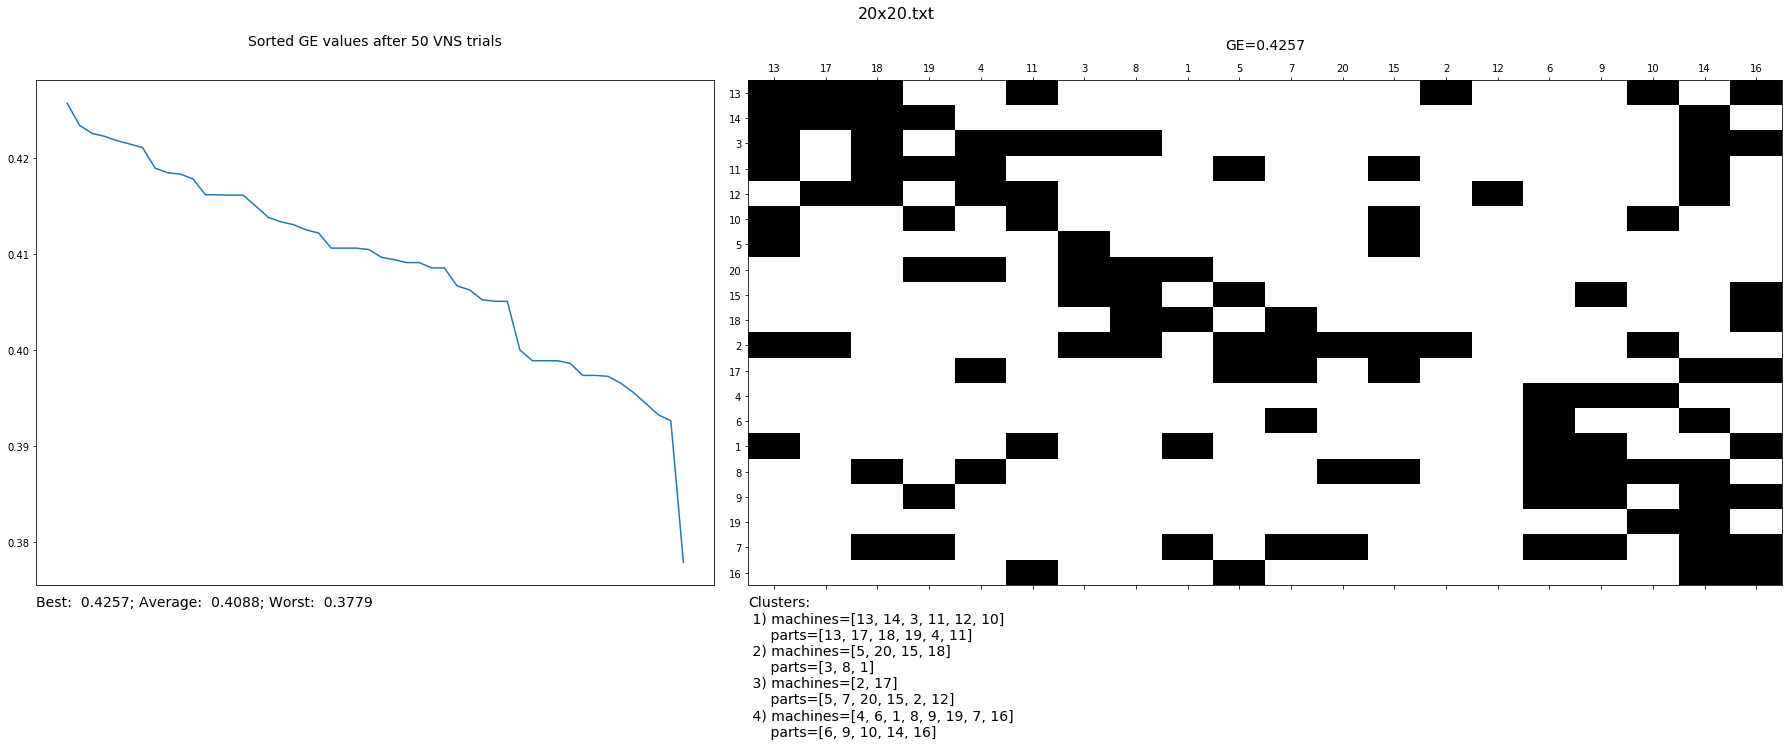

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [06:34<00:00,  8.57s/it]


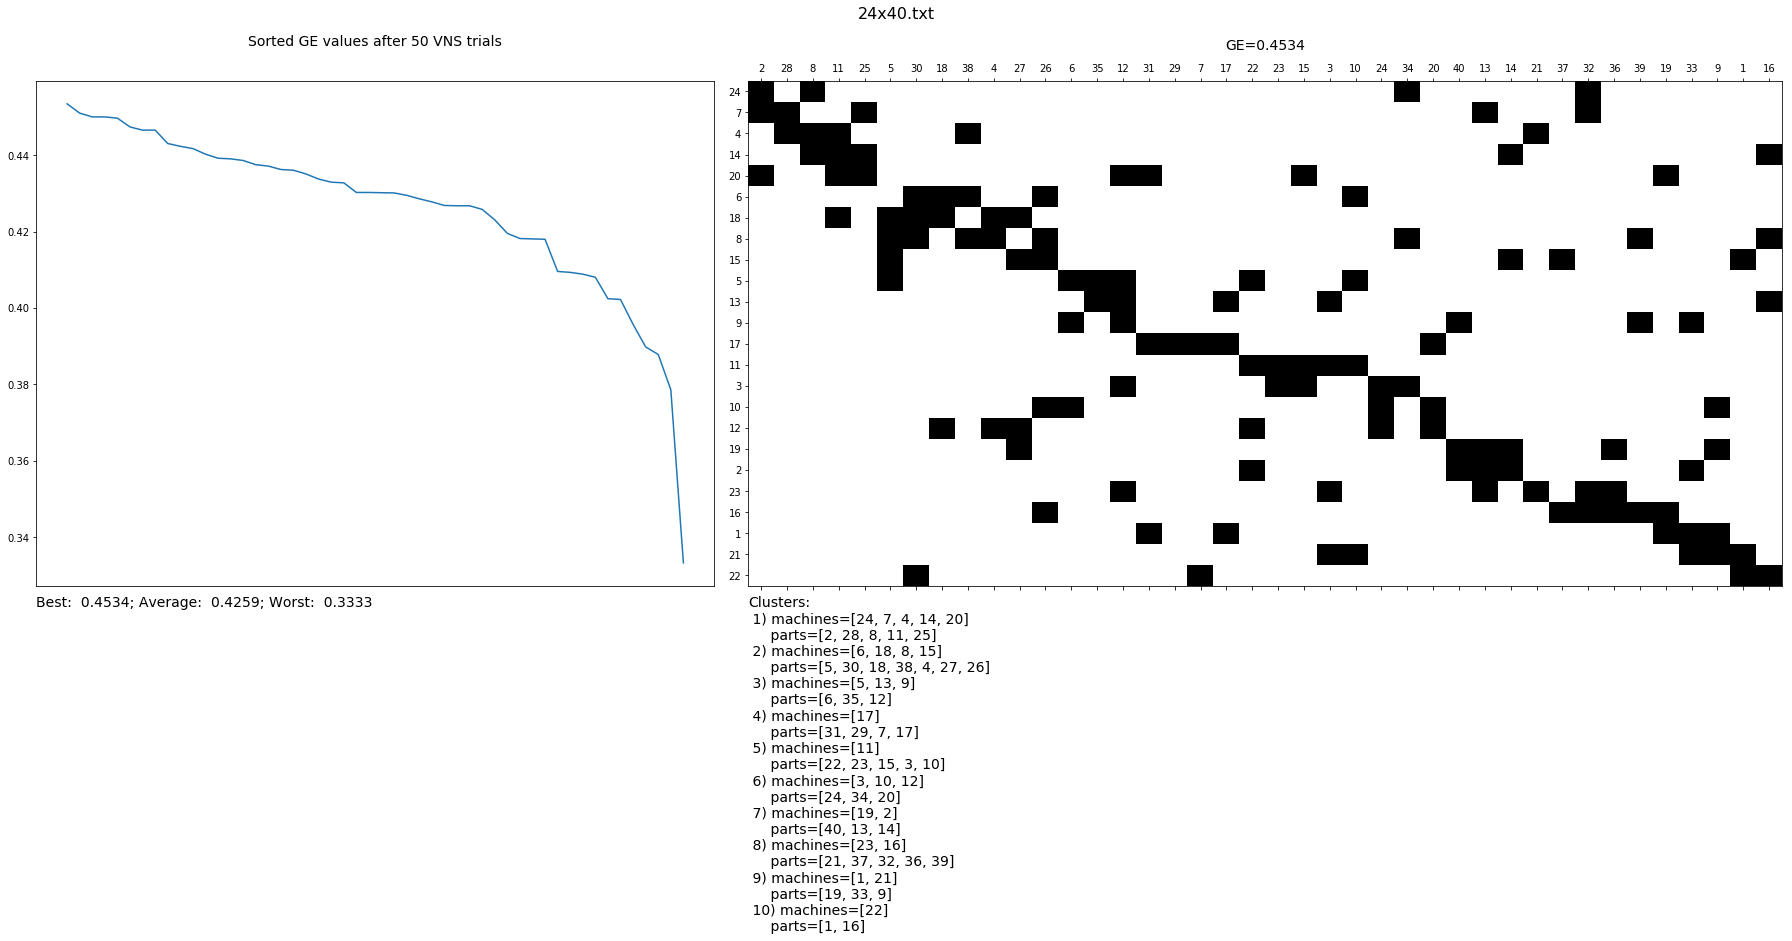

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [15:18<00:00, 19.45s/it]


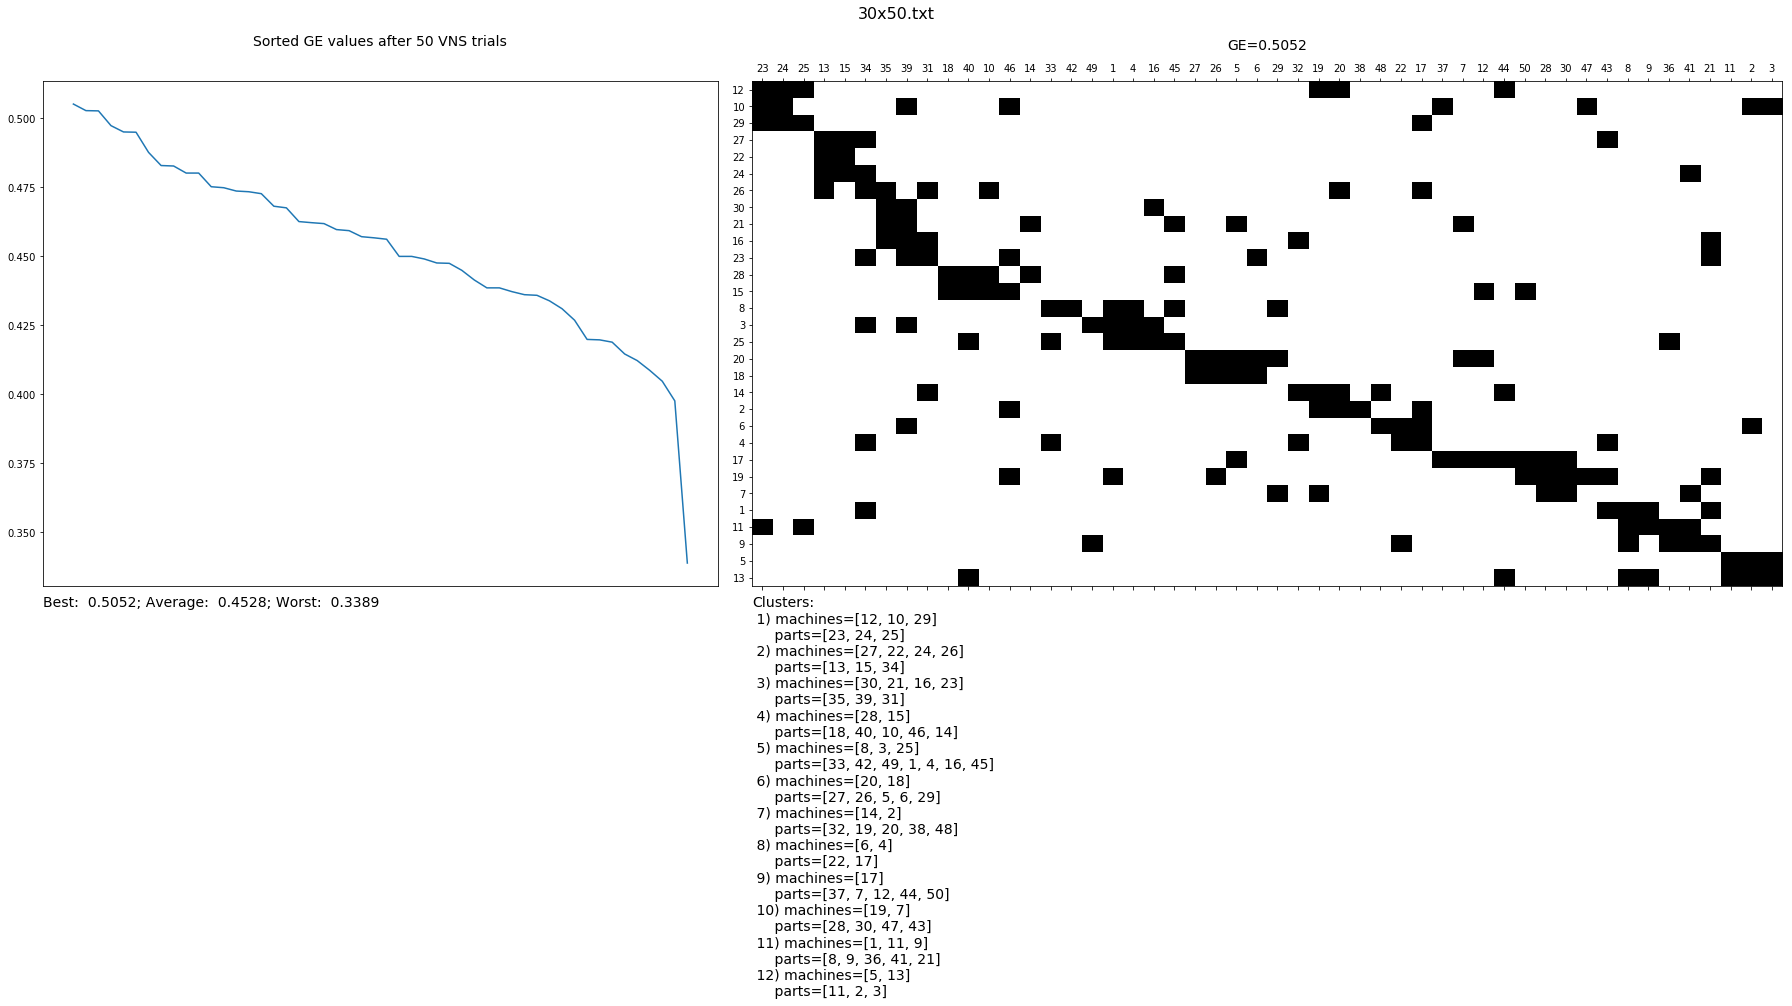

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [29:50<00:00, 31.42s/it]


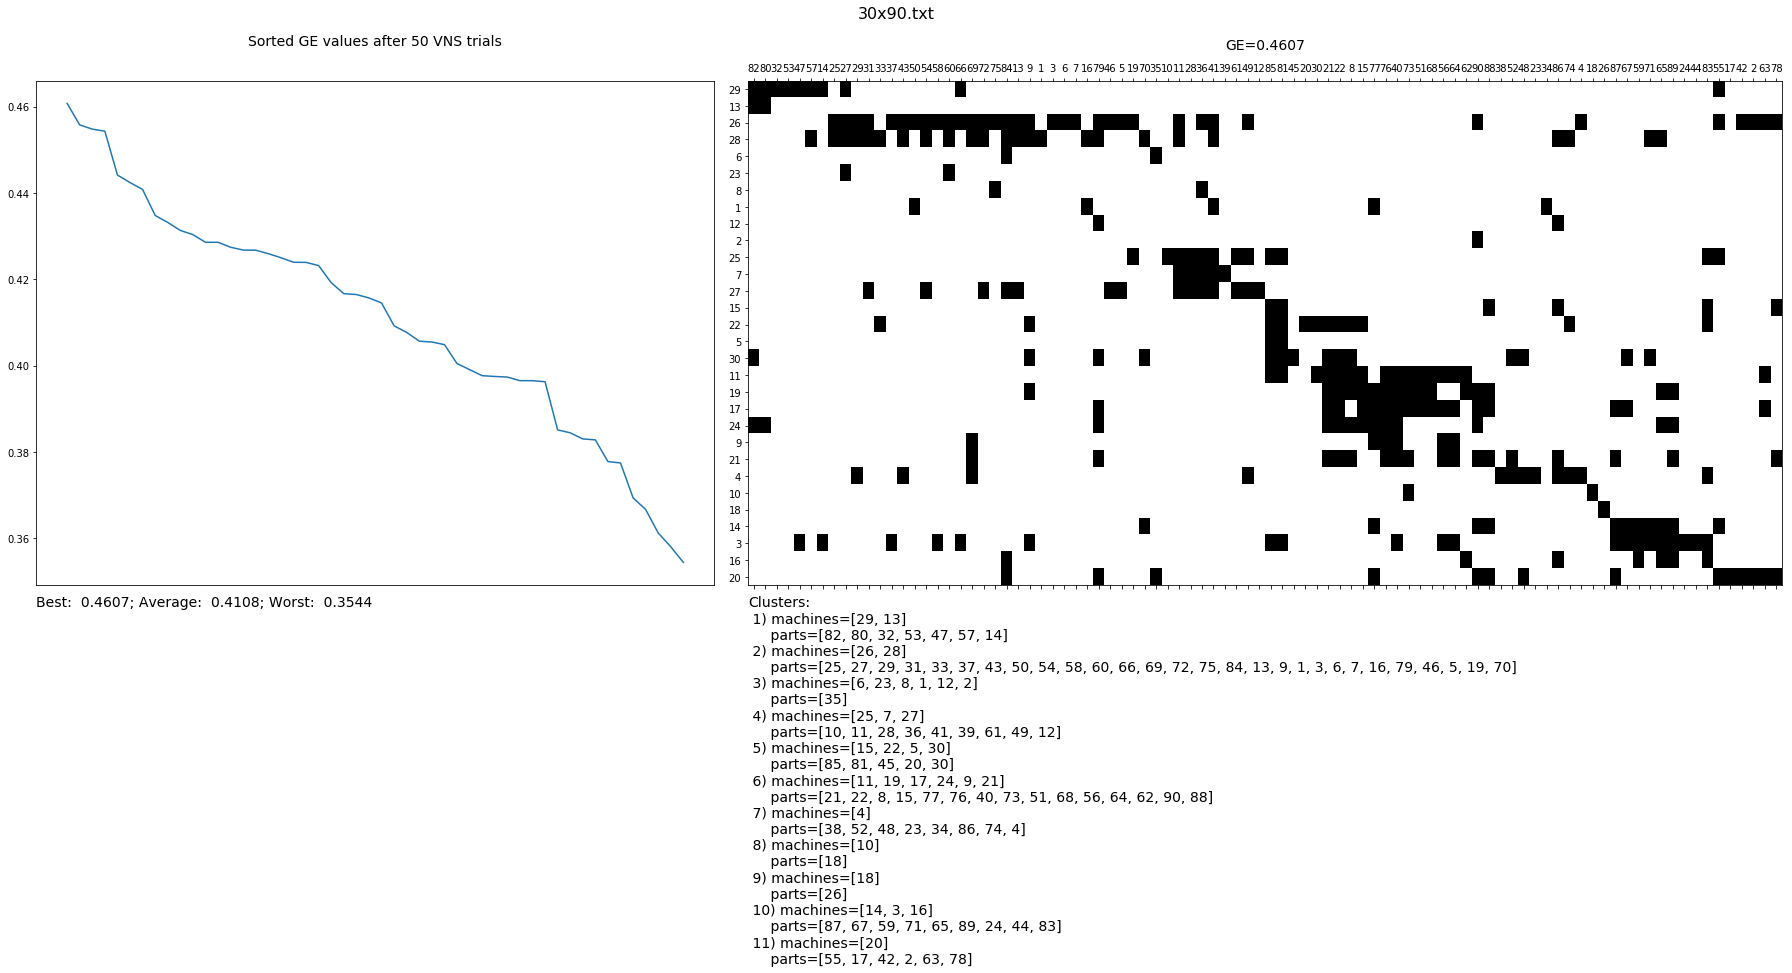

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:19<00:00,  6.10s/it]


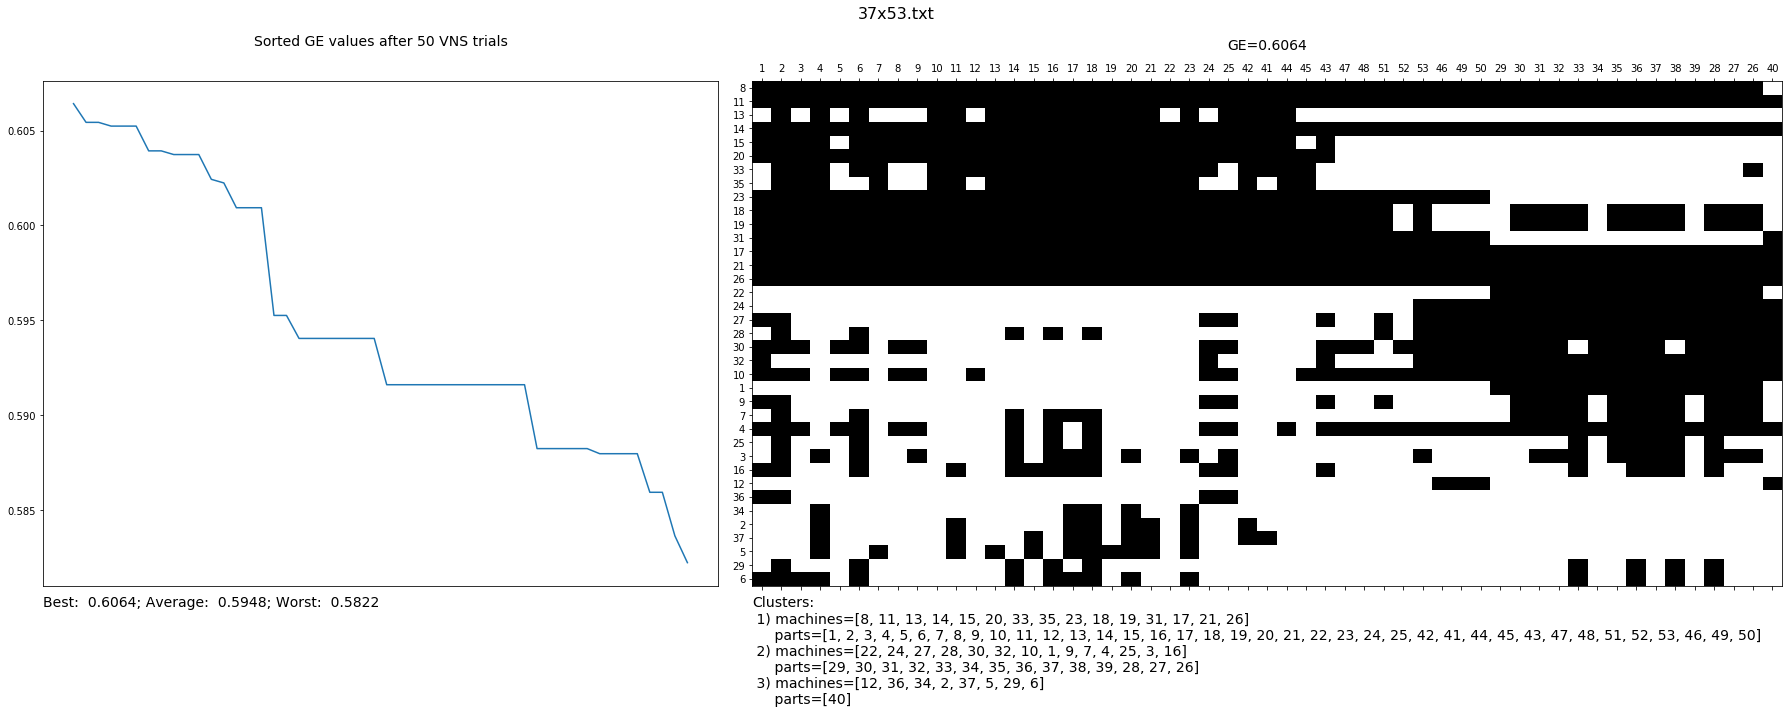

In [14]:
results = pd.DataFrame([], columns=['GE'])
n_vns_trials = 50
for instance_name in instances:
    matrix, m_ids, p_ids = read_instance_data(instances_dir, instance_name)
    init_sol = Solution(instance_name, matrix, [Cluster(machines=m_ids, parts=p_ids)])
    solutions = [vns(init_sol) for i in tqdm(range(n_vns_trials))]
    show_summary(solutions)
    best_sol = max(solutions, key=lambda s: s.ge)
    best_sol.save()
    results.loc[instance_name] = [best_sol.ge]

# Final results

In [15]:
pd.set_option('precision', 4)
results.transpose()

,20x20.txt,24x40.txt,30x50.txt,30x90.txt,37x53.txt
GE,0.4257,0.4534,0.5052,0.4607,0.6064
